# soepy

You can find the current version of soepy on the [GitHub Repo](https://github.com/OpenSourceEconomics/soepy) of OpenSourceEconomics.

Agenda:
1. My current research project
    * Reseach question and motivation
    * Economic model
2. Simulation with soepy
    * Simulation functionality
    * Introducing namedtuple
    * Descriptives and comparative statics
3. SMM estimation with soepy

## Current research project

-> see slides

## Simulation with soepy

### Simulation functionality

The soepy package simulates a data set of individual choices and experiences based on an initialization file of the form presented below.

The parameters of the model are specified under PARAMETERS and include:
* returns to education
* returns to total years of experience
* returns to experience in part-time employment
* depreciation of accumulated experience while out of employment
* disutility of work
* period wage/productivity shocks

These are potential free parameters of the model, we would ultimately wish to estimate using soepy.

Parameter values in this baseline specification are set according to estimates in Blundell (2016).

```yaml
---
GENERAL:
    num_periods: 10
    num_choices: 3
CONSTANTS:
    delta: 0.98
    mu: -0.56
    benefits: 1850.00
INITIAL_CONDITIONS:
    educ_max: 14
    educ_min: 10
SIMULATION:
    seed_sim: 102
    num_agents_sim: 1000
SOLUTION:
    seed_emax: 635
    num_draws_emax: 500
PARAMETERS:
    gamma_0s1: 5.406
    gamma_0s2: 5.574
    gamma_0s3: 6.949
    gamma_1s1: 0.152
    gamma_1s2: 0.229
    gamma_1s3: 0.306
    g_s1: 0.150
    g_s2: 0.096
    g_s3: 0.116
    delta_s1: 0.081
    delta_s2: 0.057
    delta_s3: 0.073
    theta_p: -0.10
    theta_f: -0.30
    sigma_0: 1.00
    sigma_1: 1.25
    sigma_2: 1.60
```

soepy is not a Class object. The simulation procedure comprises the consecutive execution of three main functions.

```python
def simulate(init_file_name):
    """Create a data frame of individuals' simulated experiences."""
    # Read in model specification from yaml file
    model_params = read_init_file(init_file_name)

    # Obtain model solution
    state_space_args, periods_emax = pyth_solve(model_params)

    # Simulate agents experiences according to parameters in the model specification
    dataset = pyth_simulate(model_params, state_space_args, periods_emax)
    
    [...]
    
    return dataset
```

1. Obtain state space grid and derived arguments
2. Obtain the value function maximum values for all admissible states and periods in a backward induction procedure.
3. Simulate choices and related information for a specified number of agents and periods given solution

```python
def pyth_solve(attr_dict):
    """Solve the model by backward induction."""

    # Create all necessary grids and objects related to the state space
    state_space_args = pyth_create_state_space(model_params)

    # Solve the model in a backward induction procedure
    # Error term for continuation values is integrated out
    # numerically in a Monte Carlo procedure
    periods_emax = pyth_backward_induction(model_params, state_space_args)

    # Return function output
    return state_space_args, periods_emax
```

Note:
* backward indiction is the bottleneck as far as performance is concerned
* state space arguments are analogous to "old" respy structure
* in contrast to respy additional covariates derived based on state space atributes are created only once outside the backward induction loop

### Introducing namedtuple

In soepy, the model parameters specified at initialization are passed to the following functions using [namedtuple](https://pymotw.com/2/collections/namedtuple.html).

The standard tuple uses numerical indexes to access its members. A namedtuple assigns names, as well as the numerical index, to each member.

In [1]:
import collections

Person = collections.namedtuple('Person', 'name age gender')

bob = Person(name='Bob', age=30, gender='male')
bob

Person(name='Bob', age=30, gender='male')

In [2]:
jane = Person(name='Jane', age=29, gender='female')
jane.name

'Jane'

In [3]:
for p in [ bob, jane ]:
    print ('%s is a %d year old %s' % p)

Bob is a 30 year old male
Jane is a 29 year old female


Usage in soepy:

Create namedtuple model parameters containing the specifications made in the initialization yaml file:

```python
def create_namedtuple(init_dict):

    """Transfers model specification from a dictionary
    to a named tuple class object."""

    model_params = cl.namedtuple("model_parameters", "")
    model_params.num_periods = init_dict["GENERAL"]["num_periods"]
    model_params.num_choices = init_dict["GENERAL"]["num_choices"]
    
    [...]
    
    return model_params
```

Pass the named tuple to all nested functions and call parameter using namedtuple.nameindex:

```python
def create_state_space(model_params):
    """Create state space related objects
    given state space components in model specification.
    """
    [...]
     # Loop over all periods / all ages
        for period in range(model_params.num_periods):

            # Start count for admissible state space points
            k = 0

            # Loop over all possible initial conditions for education
            for educ_years in range(model_params.educ_range):

                # Check if individual has already completed education
                # and will make a labor supply choice in the period
                if educ_years > period:
                    continue
    [...]
    return state_space_args
```

### Descriptives and comparative statics

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data_frame_baseline = pd.read_csv('toy_model_sim_benchmark1.csv', sep = '\t')

# Drop
# data_frame_baseline = data_frame_baseline.drop(['Unnamed'], axis = 1)

# Set period wage for non-employment equal to the benefits value set in the model spcification

#data_frame_baseline['Period Wage N'] = np.where(data_frame_baseline['Period Wage N'].isnull(), np.nan, 1850)

#Determine the observed wage given period choice
def get_observed_wage (row):
    if row['Choice'] == 2:
        return row['Period Wage F']
    elif row['Choice'] ==1:
        return row['Period Wage P']
    elif row['Choice'] ==0:
        return row['Period Wage N']
    else:
        return np.nan

# Add to data frame
data_frame_baseline['Wage Observed'] = data_frame_baseline.apply (lambda row: get_observed_wage (row),axis=1)

# Show
data_frame_baseline.head(16)

,Unnamed: 0,Identifier,Period,Years of Education,Choice,Systematic Wage,Period Wage N,Period Wage P,Period Wage F,Consumption Utility N,Consumption Utility P,Consumption Utility F,Flow Utility N,Flow Utility P,Flow Utility F,Wage Observed
0,0,0,0,10,2.0,33.856305,1850.0,107.711086,488.351051,-0.026436,-0.025751,-0.007268,-0.026436,-0.023300,-0.005385,488.351051
1,1,0,1,10,1.0,64.970249,1850.0,185.984536,17.682189,-0.026436,-0.018965,-0.046614,-0.026436,-0.017160,-0.034532,185.984536
2,2,0,2,10,2.0,69.637341,1850.0,12.313057,121.695346,-0.026436,-0.086747,-0.015826,-0.026436,-0.078492,-0.011724,121.695346
3,3,0,3,10,1.0,100.751285,1850.0,216.504696,22.767989,-0.026436,-0.017418,-0.040461,-0.026436,-0.015760,-0.029974,216.504696
4,4,0,4,10,2.0,105.418377,1850.0,79.411938,26.937182,-0.026436,-0.030544,-0.036824,-0.026436,-0.027637,-0.027280,26.937182
5,5,0,5,10,2.0,136.532321,1850.0,257.092091,2194.083748,-0.026436,-0.015820,-0.003134,-0.026436,-0.014315,-0.002321,2194.083748
6,6,0,6,10,2.0,167.646265,1850.0,2075.737100,705.724055,-0.026436,-0.004912,-0.005914,-0.026436,-0.004444,-0.004381,705.724055
7,7,0,7,10,2.0,198.760209,1850.0,120.204163,289.771213,-0.026436,-0.024216,-0.009736,-0.026436,-0.021912,-0.007213,289.771213
8,8,0,8,10,2.0,229.874153,1850.0,118.316117,73.096367,-0.026436,-0.024432,-0.021055,-0.026436,-0.022107,-0.015598,73.096367
9,9,0,9,10,2.0,260.988098,1850.0,185.320303,96.303787,-0.026436,-0.019003,-0.018042,-0.026436,-0.017195,-0.013366,96.303787


2.0    0.747870
1.0    0.219048
0.0    0.033083
Name: Choice, dtype: float64

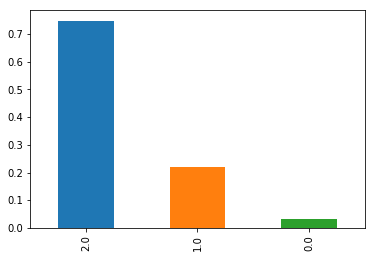

In [7]:
# Average non-employment, part-time, and full-time rates over all periods and individuals
data_frame_baseline['Choice'].value_counts(normalize=True).plot(kind = 'bar')
data_frame_baseline['Choice'].value_counts(normalize=True)

In the baseline model, the rate of non-employed over all individuals and periods is 3,3%. The part-time and full-time employment rates equal 21,9% and 74,8% respectively.

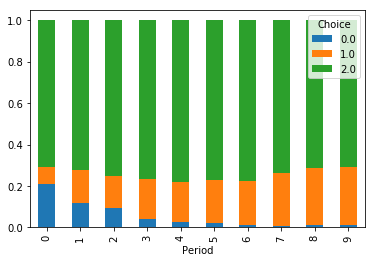

In [8]:
# Average non-employment, part-time, and full-time rates per period
data_frame_baseline.groupby(['Period'])['Choice'].value_counts(normalize=True).unstack().plot(kind = 'bar', stacked = True)

As far as the evolution of choices over all agents and periods is concerned, we first observe a declining tendency of individuals to be unemployed as desired in a perfectly calibrated simulation. Second, individuals in our Blundell benchmark simulation tend to choose full-time employment less often in the last three periods of the model. Rates of part-time employment increase for the same period. 

For a perfect calibration, full-time employment should stay roughly constant, while part-time employment should slightly decrease over time. Yet, it has to be noted that the described ideal evolution of agents' experiences might be difficult to achieve in the final periods of a ten period model. It is to be expected that the rates of part-time employment increase towards the end of the time modelled: since agents will only continue working for a few more periods, accumulation of experience through full-time employment becomes less attractive and, thus, choosing full-time employment becomes less frequent.

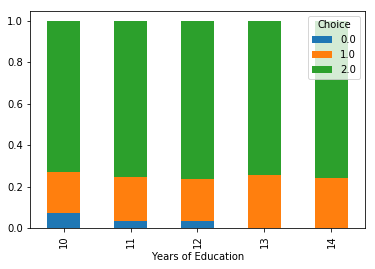

In [9]:
# Average non-employment, part-time, and full-time rates for individuals with different level of education
data_frame_baseline.groupby(['Years of Education'])['Choice'].value_counts(normalize=True).unstack().plot(kind = 'bar', stacked = True)

As should be expected, the higher the education level of the individuals the lower the observed.

We note a higher level of part-time employment than desired in an ideal callibration among individuals with high level of education (13 qnd 14 years).

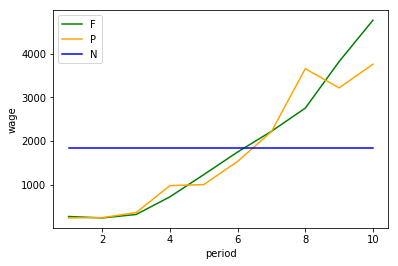

In [10]:
# Average wage for each period and choice
fig,ax = plt.subplots()

# Generate x axes values
period = [1,2,3,4,5,6,7,8,9,10]

# Generate plot lines
ax.plot(period,
        data_frame_baseline[data_frame_baseline['Choice'] == 2].groupby(['Period'])['Period Wage F'].mean(),
        color='green', label = 'F')
ax.plot(period,
        data_frame_baseline[data_frame_baseline['Choice'] == 1].groupby(['Period'])['Period Wage P'].mean(),
        color='orange', label = 'P')
ax.plot(period,
        data_frame_baseline[data_frame_baseline['Choice'] == 0].groupby(['Period'])['Period Wage N'].mean(), 
        color='blue', label = 'N')

# Plot settings
ax.set_xlabel("period")
ax.set_ylabel("wage")
ax.legend(loc='best')


The period wage of non-employment actually refers to the unemployment benefits individuals receive. The amount of the benefits is constant over time. Part-time and full-time wages rise as individuals gather more experience. However, in an idally calibrated simulation, part-time wages would need to grow more slowly compared to the Blundell benchmark model. 

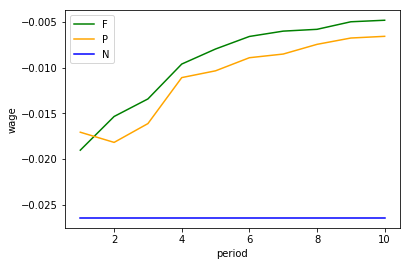

In [11]:
# Average flow utility for each period and choice

fig,ax = plt.subplots()

# Generate x axis values
period = [1,2,3,4,5,6,7,8,9,10]

# Generate lines
ax.plot(period,
        data_frame_baseline[data_frame_baseline['Choice'] == 2].groupby(['Period'])['Flow Utility F'].mean(),
        color='green', label = 'F')
ax.plot(period,
        data_frame_baseline[data_frame_baseline['Choice'] == 1].groupby(['Period'])['Flow Utility P'].mean(),
        color='orange', label = 'P')
ax.plot(period,
        data_frame_baseline[data_frame_baseline['Choice'] == 0].groupby(['Period'])['Flow Utility N'].mean(), 
        color='blue', label = 'N')

# Plot settings
ax.set_xlabel("period")
ax.set_ylabel("wage")
ax.legend(loc='best')

As expected, average flow utility of full-time employment is higher than the average flow utility of part-time employment. The flow utility of nonemployment is constant and lowest.

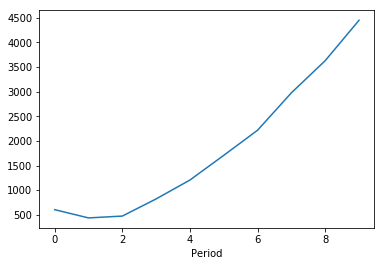

In [12]:
# Average observed wage per period
data_frame_baseline.groupby(['Period'])['Wage Observed'].mean().plot()

### Comparative statics

Finally, show a small example of coparative statics. In the alternative specifications the return to experience coefficient gamma_1 for the individuals with medium level of educations is increased from 0.229 to 0.280. As a result, experience accumulation matters more in the utility maximization. Therefore, individuals with medium level of education choose to be employed more often. Consequently, also aggregate levels of nonemployment are lower in the model.

In [13]:
data_frame_alternative = pd.read_csv('toy_model_sim_test_alternative.csv', sep = '\t')

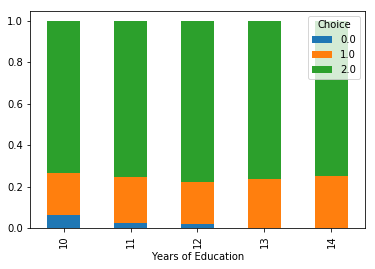

In [15]:
# Average non-employment, part-time, and full-time rates for individuals with different level of education
data_frame_alternative.groupby(['Years of Education'])['Choice'].value_counts(normalize=True).unstack().plot(kind = 'bar', stacked = True)

2.0    0.753994
1.0    0.220669
0.0    0.025337
Name: Choice, dtype: float64

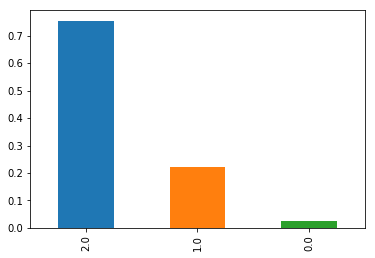

In [16]:
# Average non-employment, part-time, and full-time rates over all periods and individuals
data_frame_alternative['Choice'].value_counts(normalize=True).plot(kind = 'bar')
data_frame_alternative['Choice'].value_counts(normalize=True)

## Estimation with soepy 

SMM estimation procedure using [Py-BOBYQA](https://github.com/numericalalgorithmsgroup/pybobyqa).:
* objective function taking the parameter vector to be estimated as an argument
* calculate moments in observed (true simulated) sample

Do:
* simulate a data set based on parameter values in current optimizer iteration
* calculate moments in the resulting simulated sample
* calculate value of the objective function: weighted square loss function
* repeat until tolerance level is reached

```python
def get_objective (optim_paras):

    data_frame_observed = pd.read_csv('toy_model_sim_benchmark.csv', sep = '\t')
    moments_obs = get_moments_extended(data_frame_observed)

    weighting_matrix = get_weighting_matrix(data_frame_observed, num_agents_smm = 1000, num_samples = 100)

    # Generate simulated dataset
    data_frame = simulate_smm(optim_paras)
    
    # Calculate simulated moments
    #moments_sim = get_moments(data_frame)
    moments_sim = get_moments_extended(data_frame)

    moments_sim_list = moments_dict_to_list_extended(moments_sim)
    print (moments_sim_list)
    
    # Obtain criterion function value
    func = calculate_criterion_func_value(moments_sim, moments_obs, weighting_matrix)

    return func
```

Additional moments:
* wage distribution by period and education level
* wage distribution by years of total in labor market experience
* wage distribution by years of full time experience
* choice probability by above conditions

Note: possibly need to add higher order moments

```python
logging.basicConfig(level=logging.INFO, format='%(message)s')

soln = pybobyqa.solve (get_objective,
       optim_paras_start,
       rhobeg=0.01,
       rhoend=1e-4,
       npt = 19,
       maxfun=40,
       bounds=(lower,upper),
       scaling_within_bounds=True
       )

print(soln)
```

```text
Function eval 1 at point 1 has f = 1.99306966128103e-30 at x = [...]

[...]

Beginning main loop
Function eval 20 at point 20 has f = 0.00113259967082321 at x = [...]
New rho = 0.001 after 20 function evaluations
Function eval 21 at point 21 has f = 0.00169692512396886 at x = [...]
Function eval 22 at point 22 has f = 6.90425240693039e-06 at x = [...]
Function eval 23 at point 23 has f = 8.37248375844819e-06 at x = [...]
Function eval 24 at point 24 has f = 1.89449484107043e-06 at x = [...]
Function eval 25 at point 25 has f = 2.03818022913401e-05 at x = [...]
Function eval 26 at point 26 has f = 2.69930965293257e-05 at x = [...]
Function eval 27 at point 27 has f = 8.94893375285897e-05 at x = [...]
Function eval 28 at point 28 has f = 3.27519358887372e-06 at x = [...]
Function eval 29 at point 29 has f = 9.4048017614181e-06 at x = [...]
Function eval 30 at point 30 has f = 6.42866003552361e-06 at x = [...]
Function eval 31 at point 31 has f = 9.9354112220621e-06 at x = [...]
Function eval 32 at point 32 has f = 4.84823695997662e-06 at x = [...]
Function eval 33 at point 33 has f = 2.70228872502179e-05 at x = [...]
Function eval 34 at point 34 has f = 3.78796547613078e-06 at x = [...]
Function eval 35 at point 35 has f = 1.50684678585831e-06 at x = [...]
New rho = 0.0001 after 35 function evaluations
Function eval 36 at point 36 has f = 1.1030492710082e-06 at x = [...]
Function eval 37 at point 37 has f = 2.15224262281514e-08 at x = [...]
Function eval 38 at point 38 has f = 3.67779672709275e-07 at x = [...]
Function eval 39 at point 39 has f = 6.07523165844384e-08 at x = [...]
Function eval 40 at point 40 has f = 1.46176839453565e-06 at x = [...]
Did a total of 1 run(s)
****** Py-BOBYQA Results ******
Solution xmin = [ 5.406  5.574  6.949  0.152  0.229  0.306  0.15   0.096  0.116  0.081
  0.057  0.073 -0.1   -0.3    1.     1.25   1.6  ]
Objective value f(xmin) = 1.993069661e-30
Needed 40 objective evaluations (at 40 points)
Approximate gradient = [ 0.02820354  0.01584908  0.05903194  0.05224201  0.58762375  0.39355667
 -0.14554667 -0.44704655 -0.22041993 -0.17372473  1.67222062 -0.50666663
  0.95438106 -0.38193553 -0.14083374  0.00967395  0.0665431 ]
Not showing approximate Hessian because it is too long; check self.hessian
Exit flag = 1
Warning (max evals): Objective has been called MAXFUN times
******************************
```